# Analysis Of Trump and Biden Twitter Followers

#### First all of the import statements we will need

In [1]:
from tqdm import tqdm
import os
import twint
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import csv
import math
from math import log2
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
import graphviz

## Data Collection

#### First, we used the Python scripts in our github repository to scrape followers of Trump and Biden relying on [Twint](https://github.com/twintproject/twint)

#### We have to load in all of our data structures (matrices, lists, target arrays)

In [43]:
# We have already saved our matrix, target array, teams list, and both matrix to our local computer. 
# Follow the Python scripts on our github to do the same.

# In our case, our matrix is 2705 x 102. There are 2705 total followers of either Biden or Trump.
# Each follower is represented by a row.
matrix = np.load('matrix.npy')
# In order to get a better idea of the matrix, we recommend printing out its shape. Un-comment the below line of code:
#print(matrix.shape)

# The target array corresponds to the matrix.
# It also has 2705 rows, but only one column. The column indicates whether a user follows Trump or Biden
targetArray = np.load('targetArray.npy')
#print(targetArray.shape)

# This is a list compiled of the top 60 most followed accounts by Trump and Biden followers minus duplicates.
# Because we get rid of duplicates, the teams list has 102 elements.
# NOTE: These teams will be referred to as column accounts in the future
topTeamsListMessy = np.load('topTeamsList.npy')
#print(topTeamsListMessy.shape)

# This matrix, the both matrix, is made up of followers that follow both Trump and Biden.
# It has 782 rows and 102 columns.
bothMatrix = np.load('bothMatrix.npy')
#print(bothMatrix.shape)

#### Next, we have to clean up 'topTeamsListMessy' because it has many unwanted symbols in each entry (feel free to print elements of the list before and after cleaning to notice the messiness)

In [6]:
def cleanTeamsList(teamsList):
    cleanList = []
    for user in teamsList:
        cleanUser = user[2:-3]
        cleanList.append(cleanUser)
    return cleanList

topTeamsList = cleanTeamsList(topTeamsListMessy)
print(len(topTeamsList))

102


## Visualizing Data

#### First, we'll take a look at how many accounts are followed by users that follow Trump, Biden, and both follow on average.

In [46]:
# Find total number of followers of Trump, Biden, and both
def countNumFollowers(targetArray):
    countBiden = 0
    countTrump = 0
    for orient in targetArray:
        if orient == 0:
            countBiden += 1
        elif orient == 1:
            countTrump += 1
    return countBiden, countTrump

countBiden, countTrump = countNumFollowers(targetArray)
countBoth = len(bothMatrix)

print("Total number of Biden followers: ", countBiden)
print("Total number of Trump followers: ", countTrump)
print("Total number of both followers: ", countBoth)

Total number of Biden followers:  1381
Total number of Trump followers:  1324
Total number of both followers:  782


In [40]:
# Function that finds the total amount of followers for a given group (Trump, Biden, Both)
def findAmountFollowers(path):
    count=0
    for user in os.listdir(path):
        if user[0] != ".":
            dataframe = pd.read_csv(path+user, usecols=[0])
            following = dataframe.username.tolist()
            for account in following:
                count+=1
    return count
bidenCount = findAmountFollowers("/Users/teaganjohnson/desktop/TwitterMaster/Joe Biden Followers/")
trumpCount = findAmountFollowers("/Users/teaganjohnson/desktop/TwitterMaster/Donald Trump Followers/")
bothCount = findAmountFollowers("/Users/teaganjohnson/desktop/TwitterMaster/Both Followers/")
print("BIDEN: ", bidenCount)
print("TRUMP: ", trumpCount)
print("BOTH: ", bothCount)

BIDEN:  219330
TRUMP:  131629
BOTH:  186743


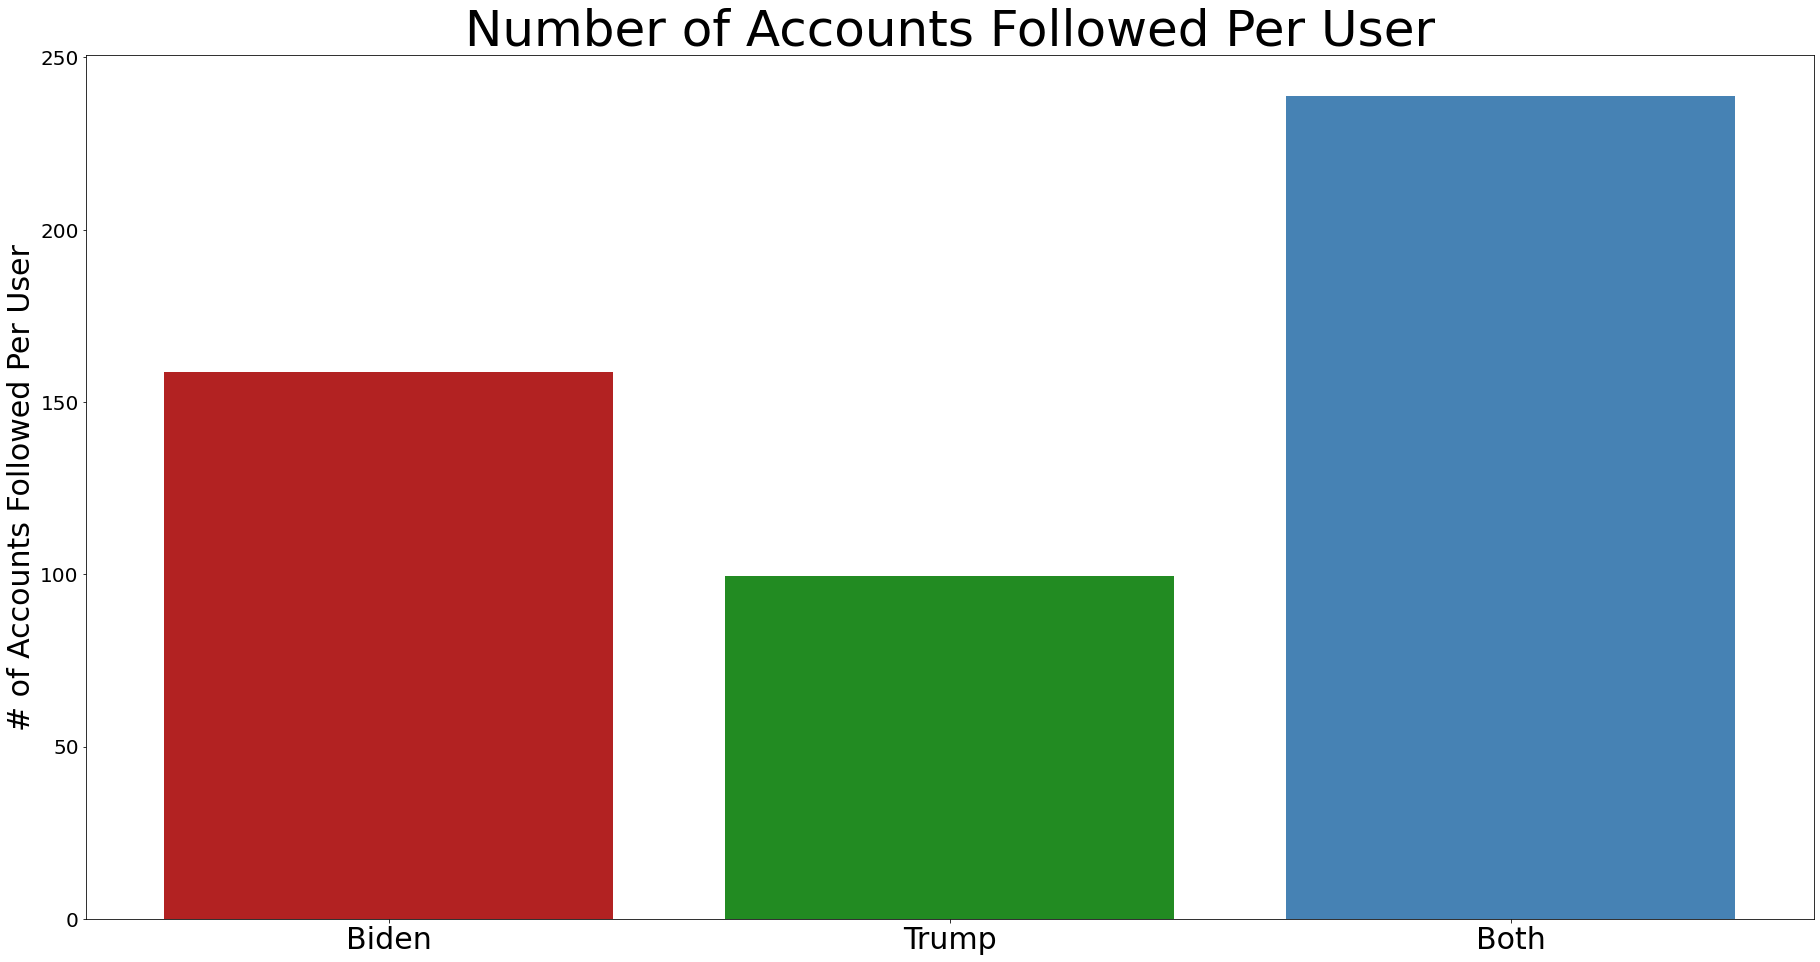

In [47]:
bidenFollowersPer = bidenCount/countBiden
trumpFollowersPer = trumpCount/countTrump
bothFollowersPer = bothCount/countBoth

# Use matplotlib to visualize the distribution
fig, ax = plt.subplots()
ax.bar(["Biden", "Trump", "Both"], [bidenFollowersPer, trumpFollowersPer, bothFollowersPer], color=['firebrick', 'forestgreen', 'steelblue'])
ax.set_title('Number of Accounts Followed Per User', fontsize=50)
ax.set_ylabel('# of Accounts Followed Per User', fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=20)
fig.subplots_adjust(left=0, right=4, top=3, bottom=0)

#### Next, lets visualize how many of the column accounts Trump and Biden followers follow on average

In [44]:
def averageFollowing(matrix1, matrix2, classification):
    totalInClass = 0
    totalFollowing = 0
    for i in range(len(matrix2)):
        if (matrix2[i] == classification):
            totalInClass += 1;
            for e in matrix1[i]:
                if (e == 1):
                    totalFollowing += 1;
    return totalFollowing / totalInClass

print("Biden followers follow " + str(averageFollowing(matrix, targetArray, 0)) + " of the 102 teams on average")
print("Trump followers follow " + str(averageFollowing(matrix, targetArray, 1)) + " of the 102 teams on average")

Biden followers follow 6.538015930485155 of the 102 teams on average
Trump followers follow 4.327794561933535 of the 102 teams on average


In [45]:
# Function that returns a list of the number of column accounts that each Trump/Biden follower follows
def createFollowingList(matrix1, matrix2, classification):
    followingList = []
    for i in range(len(matrix2)):
        if (matrix2[i] == classification):
            numFollowing = 0
            for e in matrix1[i]:
                if (e == 1):
                    numFollowing += 1;
            followingList.append(numFollowing)
    return followingList

bidenFollowingList = createFollowingList(matrix, targetArray, 0)
trumpFollowingList = createFollowingList(matrix, targetArray, 1)

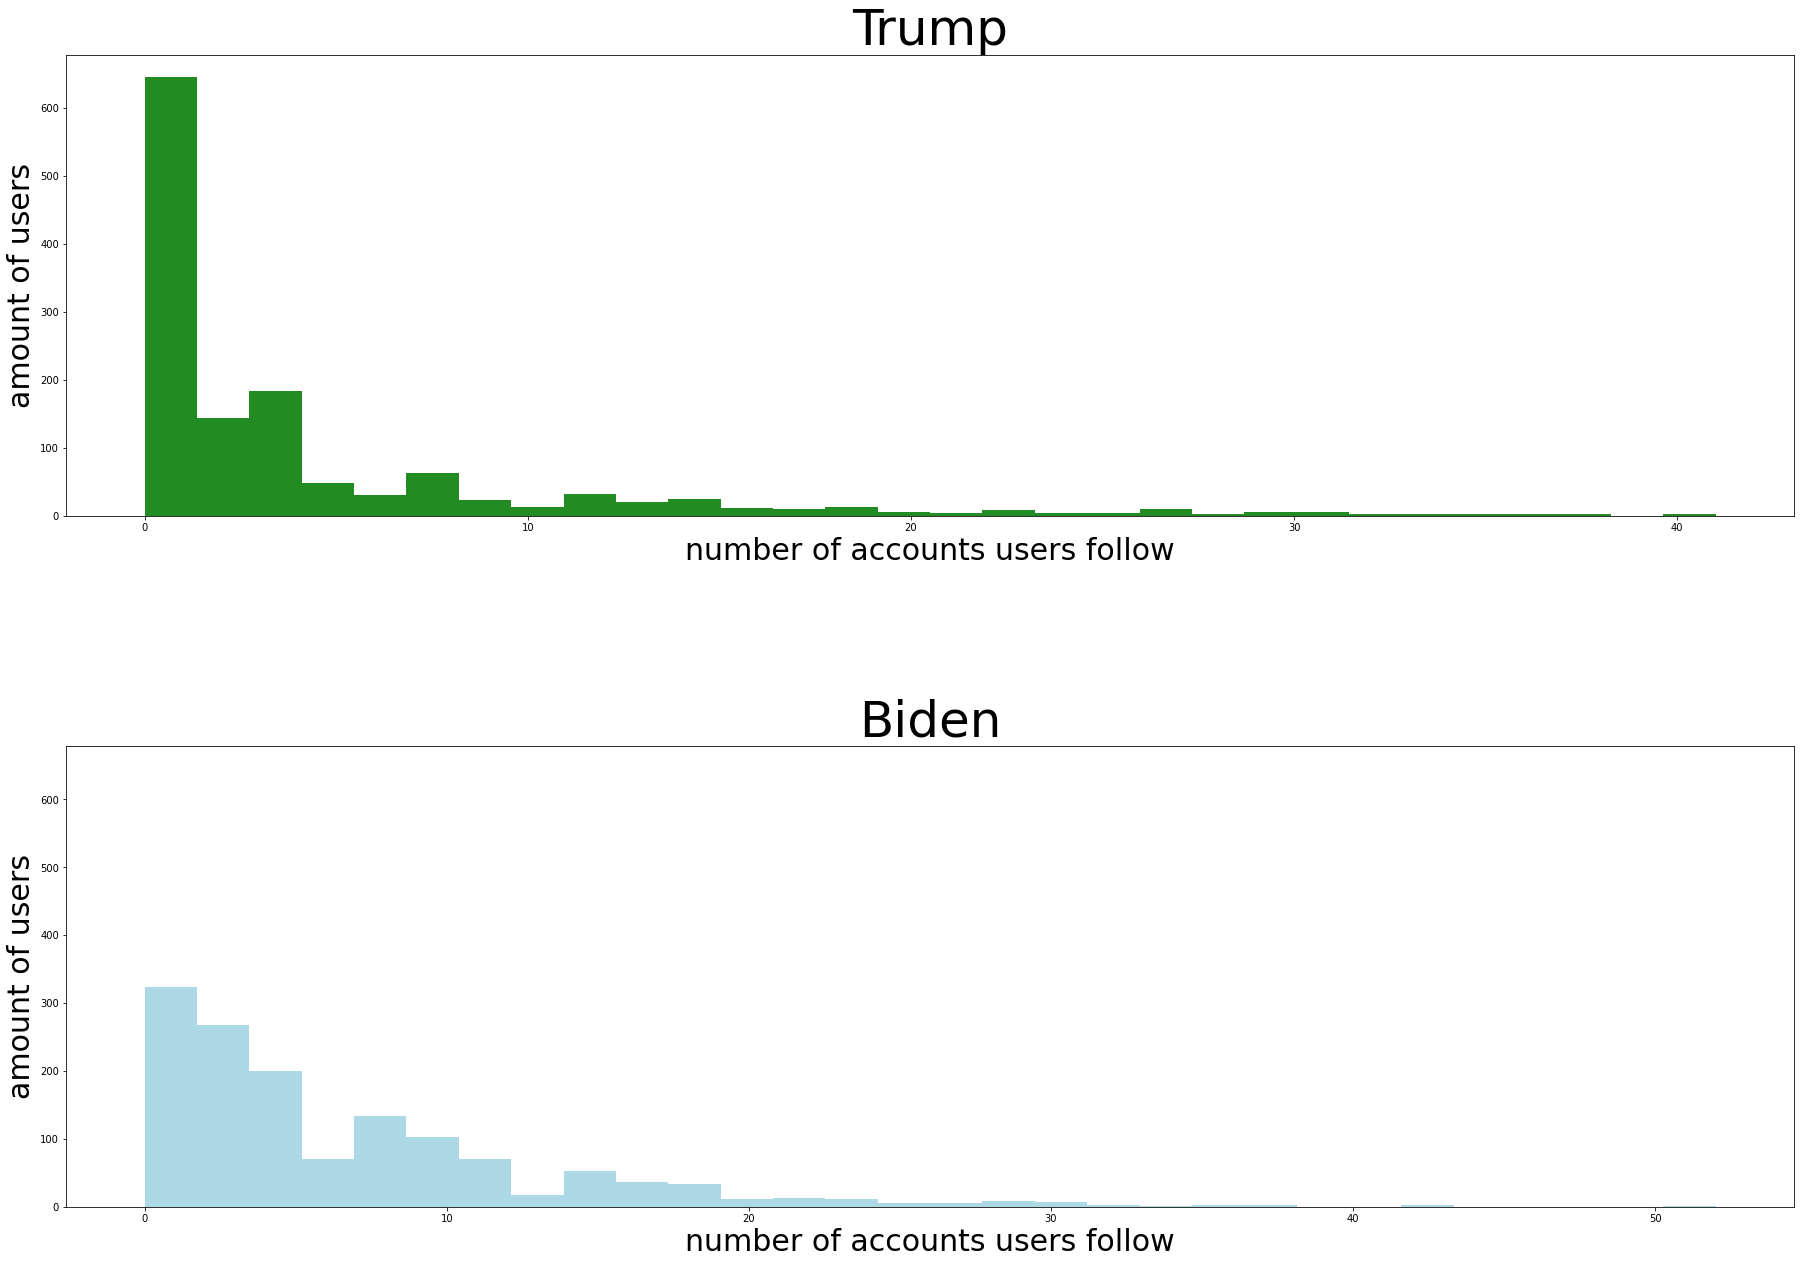

In [105]:
fig, ax = plt.subplots(2, sharey=True)

ax[0].hist(trumpFollowingList, bins = 30, color='forestgreen')
ax[0].set_title('Trump',fontsize=50)
ax[0].set_ylabel('amount of users', fontsize=30)
ax[0].set_xlabel('number of accounts users follow',fontsize=30)

ax[1].hist(bidenFollowingList, bins = 30, color='lightblue')
ax[1].set_title('Biden',fontsize=50)
ax[1].set_ylabel('amount of users',fontsize=30)
ax[1].set_xlabel('number of accounts users follow',fontsize=30)

fig.subplots_adjust(left=0, right=4, bottom=0, top=4, hspace=.5)

#### Key takeaways from these distributions:
    1. On average, users that follow Biden follow many more accounts than users that follow Trump
    2. Biden followers also follow more column accounts than Trump followers
    3. Users that follow both Biden and Trump follow more accounts than either Trump or Biden followers

#### Next, lets take a deeper look at the column accounts. We'll see which ones are the most and least popular

In [52]:
# Function that returns lists and target arrays of users that follow a given account and users that don't
def createSubgroups(matrix, targetArray, teamsList, teamSpec):
    listOfTeam = []
    listOfNotTeam = []
    teamTargetArray = []
    notTeamTargetArray = []
    
    for index, team in enumerate(teamsList):
        if team == teamSpec:
            teamIndex = index
    for index2, person in enumerate(matrix):
        if person[teamIndex] == 1:
            listOfTeam.append(person)
            if int(targetArray[index2]) == 1:
                teamTargetArray.append(1)
            else:
                teamTargetArray.append(0)
        else:
            listOfNotTeam.append(person)
            if int(targetArray[index2]) == 1:
                notTeamTargetArray.append(1)
            else:
                notTeamTargetArray.append(0)
    return listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray

listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeamsList, 'KamalaHarris')

print("Column account input: KAMALAHARRIS")
print("Number of users following Kamala Harris: ", len(listOfTeam))
print("Number of users not following Kamala Harris: ", len(listOfNotTeam))


Column account input: KAMALAHARRIS
Number of users following Kamala Harris:  656
Number of users not following Kamala Harris:  2049


In [54]:
# Function that returns number of users that follow Trump and Biden given a group of users and its target array
def findTrumpBiden(group, targetArray):
    countTrump = 0
    countBiden = 0
    for index, person in enumerate(group):
        if targetArray[index] == 1:
            countTrump += 1
        else:
            countBiden += 1
    return countTrump, countBiden
countTrump, countBiden = findTrumpBiden(listOfTeam, teamTargetArray)
print("# of Biden followers following Kamala Harris: ", countBiden)
print("# of Trump followers following Kamala Harris: ", countTrump)

# of Biden followers following Kamala Harris:  632
# of Trump followers following Kamala Harris:  24


In [55]:
# Function that returns dictionaries for Biden and Trump.
# The keys are column accounts and the values are the corresponding number of users that follow them
def createDicts(matrix, targetArray, topTeams):
    dictBiden = {}
    dictTrump = {}
    for index, team in enumerate(topTeams):
        listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeamsList, team)
        countTrump, countBiden = findTrumpBiden(listOfTeam, teamTargetArray)
        dictBiden[team] = countBiden
        dictTrump[team] = countTrump
    return dictBiden, dictTrump

BidenDict, TrumpDict = createDicts(matrix, targetArray, topTeamsList)

In [71]:
# This code block sorts the Biden and Trump dictionaries by most popular accounts
countedBidenDict = Counter(BidenDict)
topTenBiden = countedBidenDict.most_common(10)
bottomTenBiden = countedBidenDict.most_common()[-10:-1]

countedTrumpDict = Counter(TrumpDict)
topTenTrump = countedTrumpDict.most_common(10)
bottomTenTrump = countedBidenDict.most_common()[-10:-1]


topTenBiden = dict(topTenBiden)
topTenTrump = dict(topTenTrump)

print("Top ten column accounts followed by Biden followers:")
print(topTenBiden)
print()

print("Top ten column accounts followed by Trump followers:")
print(topTenTrump)
print()

Top ten column accounts followed by Biden followers:
{'BarackObama': 673, 'KamalaHarris': 632, 'MichelleObama': 296, 'ArianaGrande': 267, 'CNN': 240, 'HillaryClinton': 222, 'AOC': 206, 'NASA': 204, 'cnnbrk': 194, 'BernieSanders': 193}

Top ten column accounts followed by Trump followers:
{'POTUS': 336, 'DonaldJTrumpJr': 175, 'FLOTUS': 155, 'VP': 154, 'WhiteHouse': 154, 'SidneyPowell1': 149, 'BarackObama': 141, 'IvankaTrump': 138, 'elonmusk': 133, 'PressSec': 132}



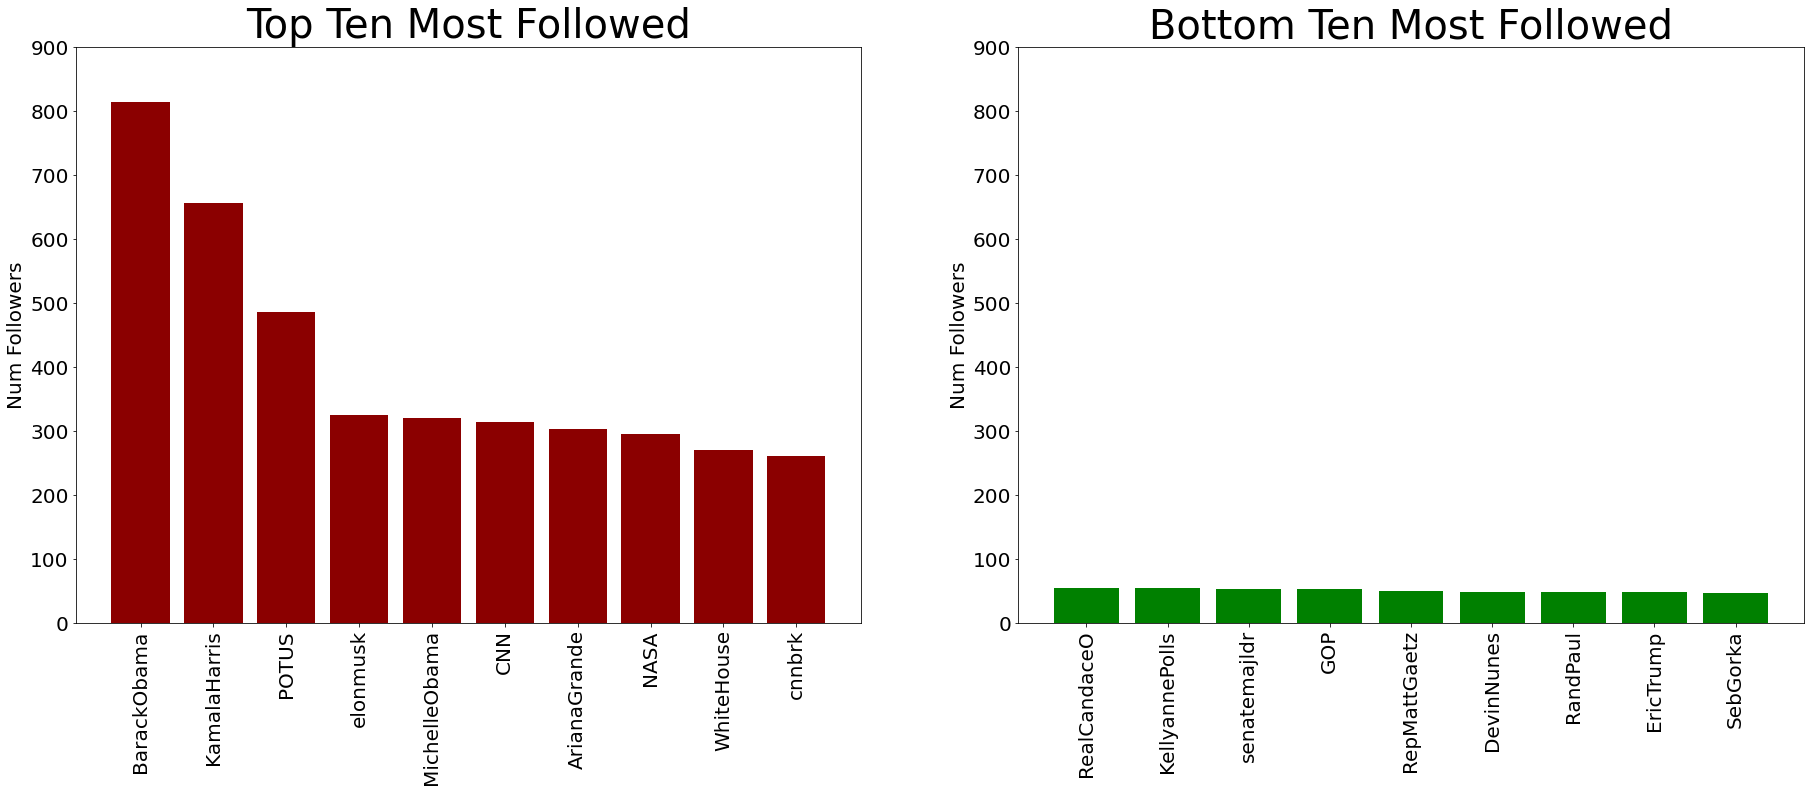

In [72]:
# Function that combines 2 dictionaries by looking at the keys
def merge_two_dicts(dict1, dict2):
    both = dict1.copy()   
    both.update(dict2)    
    return both

totalCounter = Counter(merge_two_dicts(countedBidenDict, countedTrumpDict))
topTenMostFollowed = dict(totalCounter.most_common(10))
bottomTenMostFollowed = dict(totalCounter.most_common()[-10:-1])
totalCounterSorted = dict(totalCounter.most_common(len(totalCounter)))

fig, ax = plt.subplots(1, 2)
ax[0].bar(topTenMostFollowed.keys(), topTenMostFollowed.values(), color='darkred')
ax[0].tick_params(axis='x', rotation=90, labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_ylim(0,900)
ax[0].set_ylabel('Num Followers', fontsize=20)
ax[0].set_title('Top Ten Most Followed', fontsize=40)
ax[1].bar(bottomTenMostFollowed.keys(), bottomTenMostFollowed.values(), color='green')
ax[1].tick_params(axis='x', rotation=90, labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_ylim(0,900)
ax[1].set_ylabel('Num Followers', fontsize=20)
ax[1].set_title('Bottom Ten Most Followed', fontsize=40)

fig.subplots_adjust(left=0, right=4, top=2, bottom=0, hspace=.75)

#### Above is a zoomed in look at the top 10 most and least followed column accounts. Below is the zoomed out version.

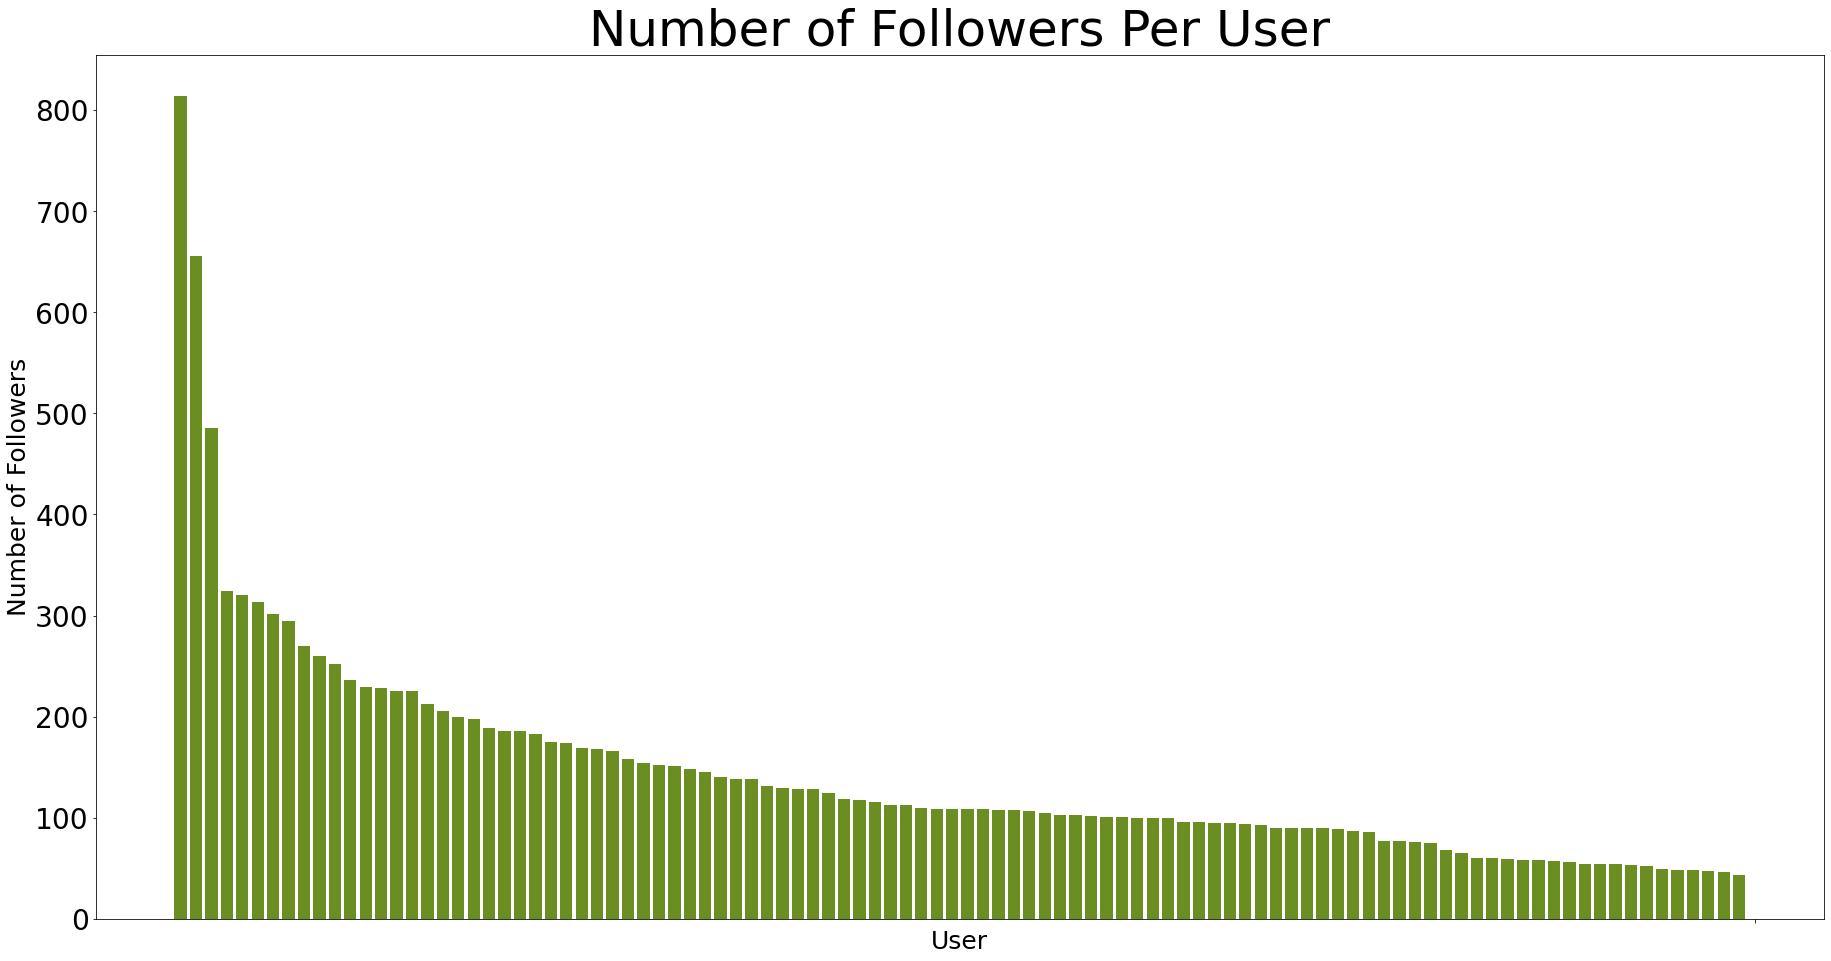

In [75]:
fig, ax = plt.subplots()
ax.bar(totalCounterSorted.keys(), totalCounterSorted.values(), color='olivedrab')
ax.set_xticks("")
ax.tick_params(axis='y', labelsize=28)
ax.set_title('Number of Followers Per User', fontsize=50)
ax.set_ylabel('Number of Followers', fontsize=25)
ax.set_xlabel('User', fontsize=25)
fig.subplots_adjust(left=0, right=4, top=3, bottom=0)

#### Now, let's analyze the distribution between followers between Trump and Biden's top 10 column accounts with eachother.

In [76]:
# Function that returns dictionaries that are alligned by either Trump or Biden's top column accounts
def allignTopTen(topTenCounter):
    trumperDict =  {}
    BidenDict =  {}
    for key in topTenCounter.keys():
        listOfTeam, listOfNotTeam, teamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeamsList, key)
        countTrump, countBiden = findTrumpBiden(listOfTeam, teamTargetArray)
        trumperDict[key] = countTrump
        BidenDict[key] = countBiden
    return trumperDict, BidenDict

trumpAlignedBiden, bidenAlignedBiden = allignTopTen(topTenBiden)
trumpAlignedTrump, bidenAlignedTrump = allignTopTen(topTenTrump)

print("Alligned by most popular Biden column accounts:")
print()
print("TRUMP: ", trumpAlignedBiden)
print()
print("BIDEN: ", bidenAlignedBiden)
print()
print()
print()
print("Alligned by most popular Trump column accounts:")
print()
print("TRUMP: ", trumpAlignedTrump)
print()
print("BIDEN: ", bidenAlignedTrump)

Alligned by most popular Biden column accounts:

TRUMP:  {'BarackObama': 141, 'KamalaHarris': 24, 'MichelleObama': 24, 'ArianaGrande': 35, 'CNN': 73, 'HillaryClinton': 30, 'AOC': 23, 'NASA': 91, 'cnnbrk': 66, 'BernieSanders': 19}

BIDEN:  {'BarackObama': 673, 'KamalaHarris': 632, 'MichelleObama': 296, 'ArianaGrande': 267, 'CNN': 240, 'HillaryClinton': 222, 'AOC': 206, 'NASA': 204, 'cnnbrk': 194, 'BernieSanders': 193}



Alligned by most popular Trump column accounts:

TRUMP:  {'POTUS': 336, 'DonaldJTrumpJr': 175, 'FLOTUS': 155, 'VP': 154, 'WhiteHouse': 154, 'SidneyPowell1': 149, 'BarackObama': 141, 'IvankaTrump': 138, 'elonmusk': 133, 'PressSec': 132}

BIDEN:  {'POTUS': 150, 'DonaldJTrumpJr': 25, 'FLOTUS': 51, 'VP': 32, 'WhiteHouse': 116, 'SidneyPowell1': 2, 'BarackObama': 673, 'IvankaTrump': 28, 'elonmusk': 191, 'PressSec': 22}


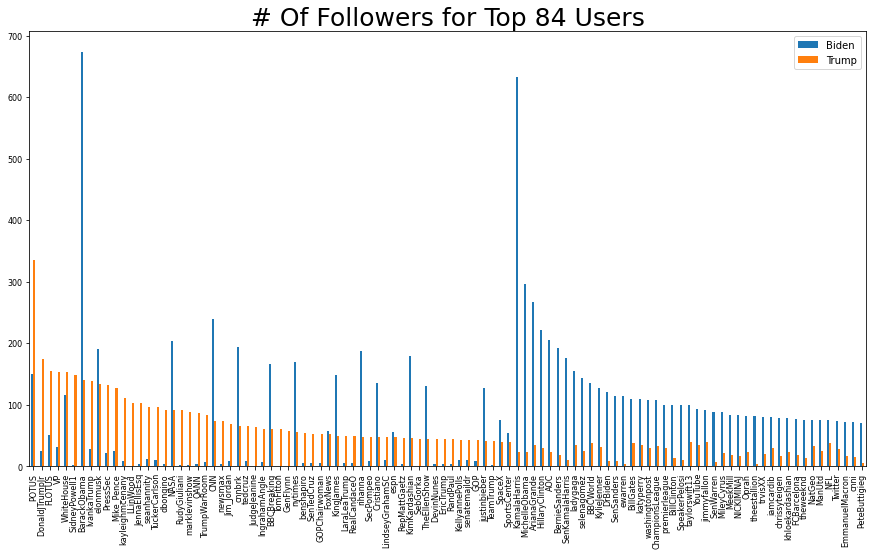

In [78]:
allGraph = pd.DataFrame(dict(Biden=list(BidenDict.values()), Trump=list(TrumpDict.values())), index=TrumpDict.keys())
bothGraph = allGraph.plot.bar(title="# Of Followers for Top 84 Users", fontsize=8, figsize=(15,8))
bothGraph.title.set_size(25)

#### As we can see, there is a clear discrepancy between top accounts followed by Trump and Biden. This shows a possible degree of polarization. Below is a zoomed in look at the top ten most followed Trump and Biden column accounts.

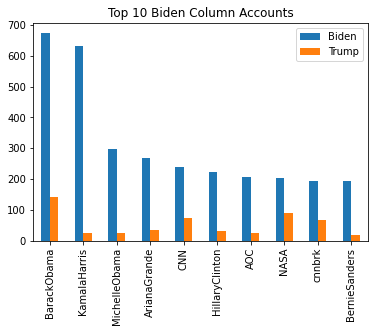

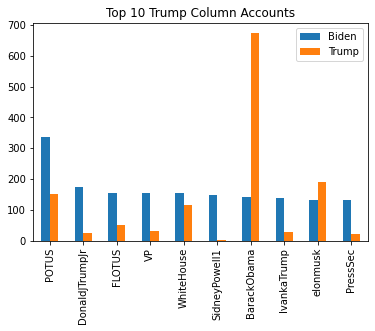

In [79]:
bidenGraph1 = pd.DataFrame(dict(Biden=list(dict(bidenAlignedBiden).values()), Trump=list(dict(trumpAlignedBiden).values())), index=topTenBiden.keys())
bidenGraph = bidenGraph1.plot.bar(title="Top 10 Biden Column Accounts")


trumpGraph1 = pd.DataFrame(dict(Biden=list(dict(trumpAlignedTrump).values()), Trump=list(dict(bidenAlignedTrump).values())), index=topTenTrump.keys())
trumpGraph = trumpGraph1.plot.bar(title="Top 10 Trump Column Accounts")

#### Because users that follow Biden tend to follow more accounts on Twitter, we should look at the normalized distribution of Trump and Biden followers across all 102 column accounts.

0.625978240103099


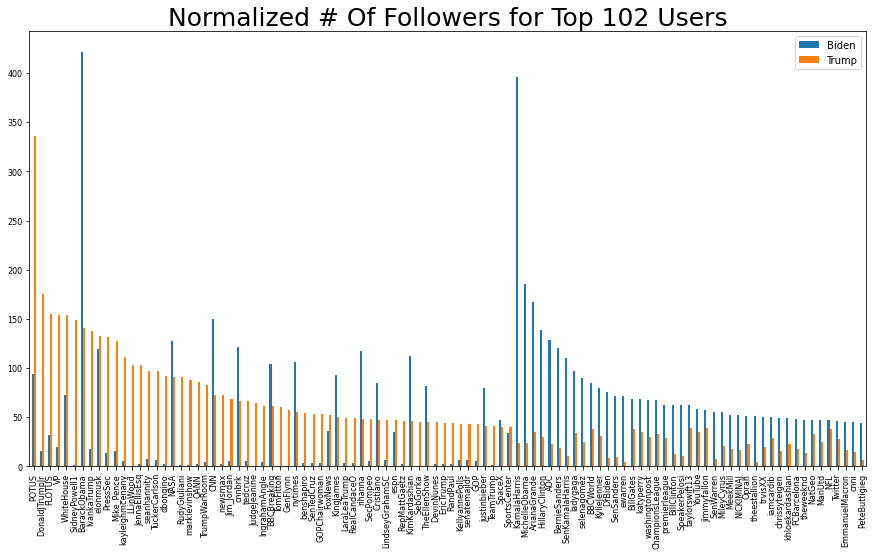

In [37]:
scale = trumpFollowersPer/bidenFollowersPer
print(scale)

newBidenList = []
for num in BidenDict.values():
    newNum = num * scale
    newBidenList.append(newNum)
allGraph = pd.DataFrame(dict(Biden=list(newBidenList), Trump=list(TrumpDict.values())), index=TrumpDict.keys())
bothGraph = allGraph.plot.bar(title="Normalized # Of Followers for Top 102 Users", fontsize=8, figsize=(15,8))
bothGraph.title.set_size(25)

#### This shows an even greater discrepancy between Trump and Biden followers, reinforcing the theory of polarization.

## Entropy Analysis (Section needs to be commented on)

#### Now, we will focus on analyzing the shannon entropies of our matrix and target array.

In [80]:
# Function that returns the shannon entropy of a vector with 2 elements
def shannonEntropy(vector):

    listOfElements = []
    for p in vector:
        if p > 0:
            element = p*log2(p)
            listOfElements.append(element)
        else:
            element = 0
            listOfElements.append(element)
        entropy = -1 * sum(listOfElements)
    return entropy

In [81]:
# Function that returns the shannon entropy given a group, its target array, and the group's larger matrix.
def findShannonEntropy(groupTeam, teamTargetArray, matrix):
    countTrumpTeam, countBidenTeam = findTrumpBiden(groupTeam, teamTargetArray)
    if (countTrumpTeam + countBidenTeam) != 0:
        probTrumpTeam = countTrumpTeam / (countTrumpTeam + countBidenTeam)
        probBidenTeam = countBidenTeam / (countTrumpTeam + countBidenTeam)
    else:
        probTrumpTeam = 0
        probBidenTeam = 0

    probTeamVector = [probTrumpTeam, probBidenTeam]
    sEntropy = shannonEntropy(probTeamVector)
    return sEntropy

In [83]:
# Function that returns weighted average entropy given a group, its target array, and the group's larger matrix.
def findWeightedShannonEntropy(groupTeam, teamTargetArray, matrix):
    countTrumpTeam, countBidenTeam = findTrumpBiden(groupTeam, teamTargetArray)
    if (countTrumpTeam + countBidenTeam) != 0:
        probTrumpTeam = countTrumpTeam / (countTrumpTeam + countBidenTeam)
        probBidenTeam = countBidenTeam / (countTrumpTeam + countBidenTeam)
    else:
        probTrumpTeam = 0
        probBidenTeam = 0

    probTeamVector = [probTrumpTeam, probBidenTeam]
    sEntropy = shannonEntropy(probTeamVector)
    wae = sEntropy * (len(groupTeam)/len(matrix))
    return wae

waeTeam = findWeightedShannonEntropy(listOfTeam, teamTargetArray, matrix)
waeNotTeam = findWeightedShannonEntropy(listOfNotTeam, notTeamTargetArray, matrix)
print("Weighted Average Entropy of team of POTUS User: ", waeTeam)
print("Weighted Average Entropy of NOT team of POTUS User:", waeNotTeam)

Weighted Average Entropy of team of POTUS User:  0.05490779377605402
Weighted Average Entropy of NOT team of POTUS User: 0.7174827199548532


In [84]:
# Function that returns the weighted average entropies of a split. This is considered the split WAE
def getSplitWAE(groupTeam, groupNotTeam, teamTargetArray, notTeamTargetArray, matrix):
        wae1 = findWeightedShannonEntropy(groupTeam, teamTargetArray, matrix)
        
        wae2 = findWeightedShannonEntropy(groupNotTeam, notTeamTargetArray, matrix)

        return (wae1 + wae2)

10 Lowest Entropies:  [('KamalaHarris', 0.6959247681186791), ('BarackObama', 0.7893109936251377), ('SidneyPowell1', 0.8197709548700725), ('DonaldJTrumpJr', 0.830123671349083), ('LLinWood', 0.8447126012364666), ('JennaEllisEsq', 0.8594088980613421), ('MichelleObama', 0.8596712126634839), ('kayleighmcenany', 0.866138304459396), ('PressSec', 0.8692769935520105), ('marklevinshow', 0.8713791064850861)]
10 Highest Entropies:  [('elonmusk', 0.9525661138780704), ('SportsCenter', 0.9521581806931647), ('NFL', 0.9518575322367444), ('espn', 0.9517628263997946), ('SpaceX', 0.9515712398744121), ('NatGeo', 0.9511209076820859), ('FoxNews', 0.9507572483171212), ('jimmyfallon', 0.950001475925825), ('iamcardib', 0.9490219799926635), ('taylorswift13', 0.948280962123702)]


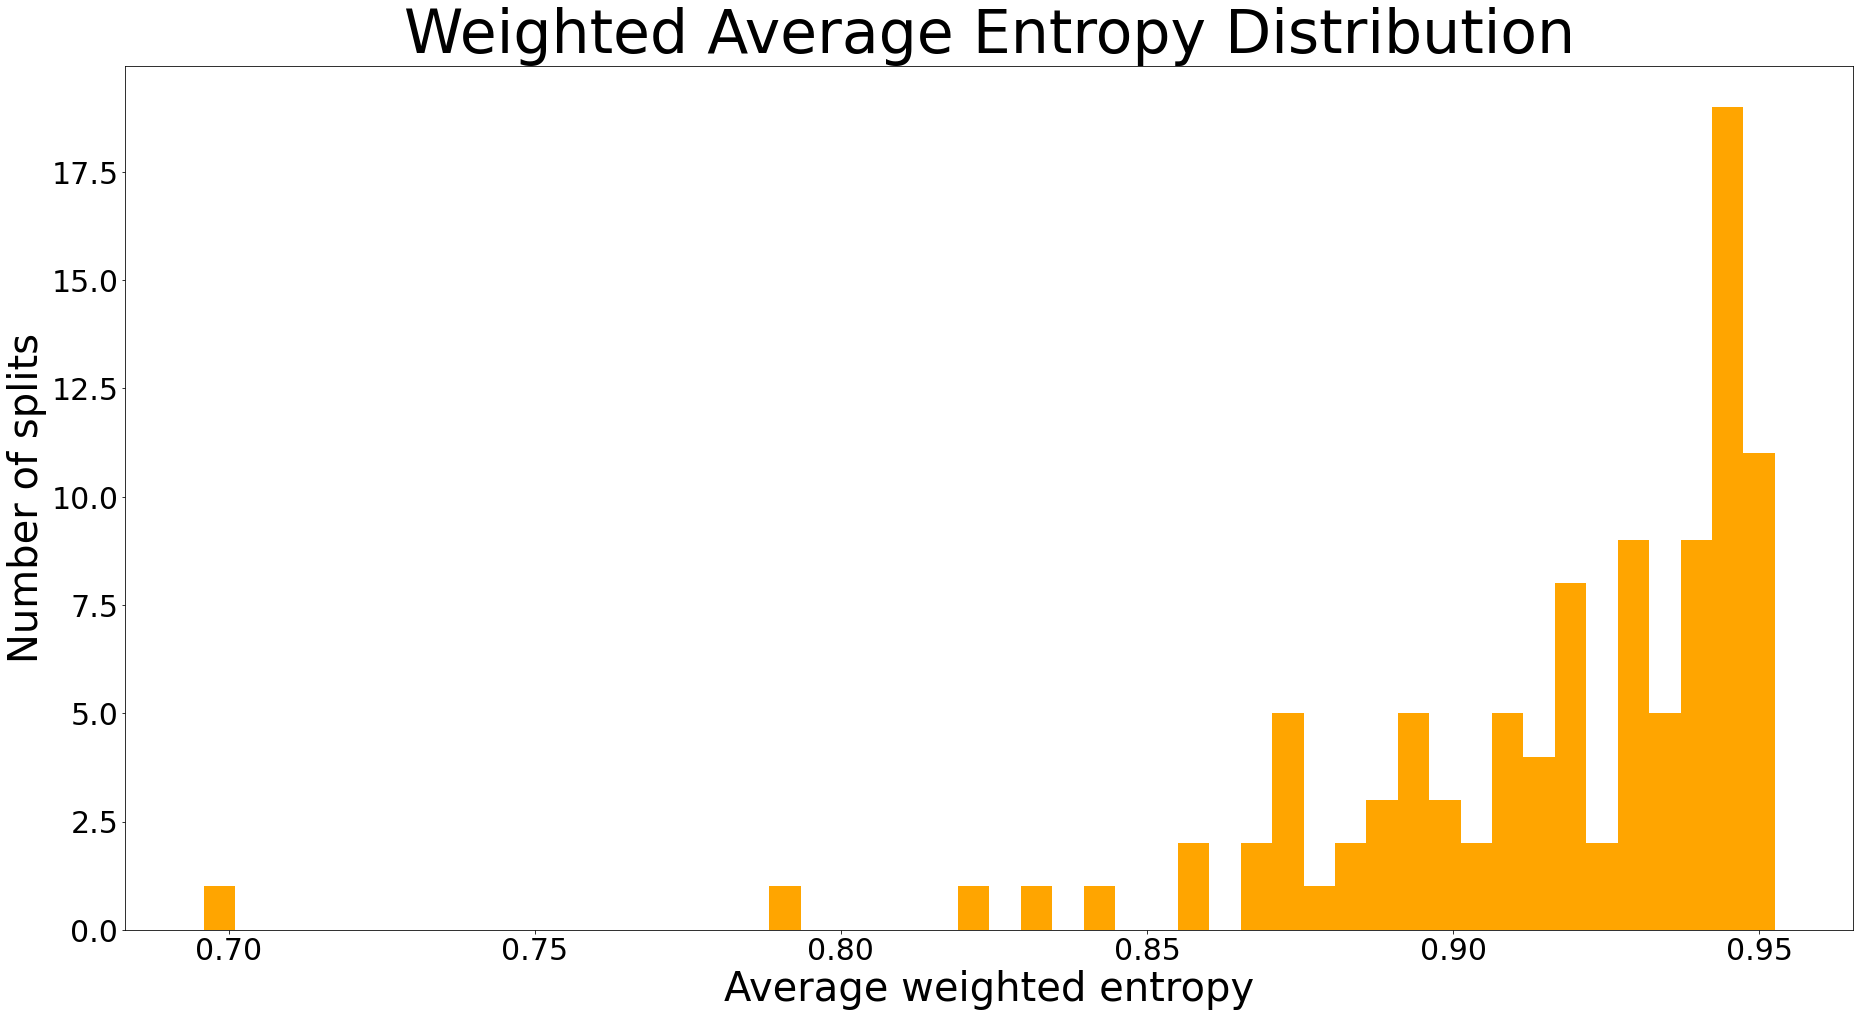

In [85]:
# Function that returns a dictionary where the keys are column account names and the values are their split WAEs.
def createWAEDict(matrix, targetArray, topTeams):
    dictWAE = defaultdict(float)
    for index, team in enumerate(topTeams):
        groupTeam, groupNotTeam, TeamTargetArray, notTeamTargetArray = createSubgroups(matrix, targetArray, topTeams, team)
        teamWAE = getSplitWAE(groupTeam, groupNotTeam, TeamTargetArray, notTeamTargetArray, matrix)
        dictWAE[team] = teamWAE
    return dictWAE

dictOfwae = createWAEDict(matrix, targetArray, topTeamsList)
dictOfwaeSmaller = createWAEDict(matrix3, targetArray3, topTeamsList)

counterWAE = Counter(dictOfwaeSmaller)

fig, ax1 = plt.subplots()
ax1.hist(counterWAE.values(), color='orange', bins = 50)
ax1.set_title('Weighted Average Entropy Distribution', fontsize=60)
ax1.set_xlabel('Average weighted entropy', fontsize=40)
ax1.set_ylabel('Number of splits', fontsize=40)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
fig.subplots_adjust(left=0, right=4, bottom=0, top=3)

print("10 Lowest Entropies: ", counterWAE.most_common()[:-10-1:-1])
print("10 Highest Entropies: ", counterWAE.most_common(10))

#### As we can see above, most column accounts have WAEs that are closer to .95. This means that the split is not especially homogenous (the column account doesn't indicate follower preference). However, there are many accounts that are below .90 which indicates high levels of homogeneity.

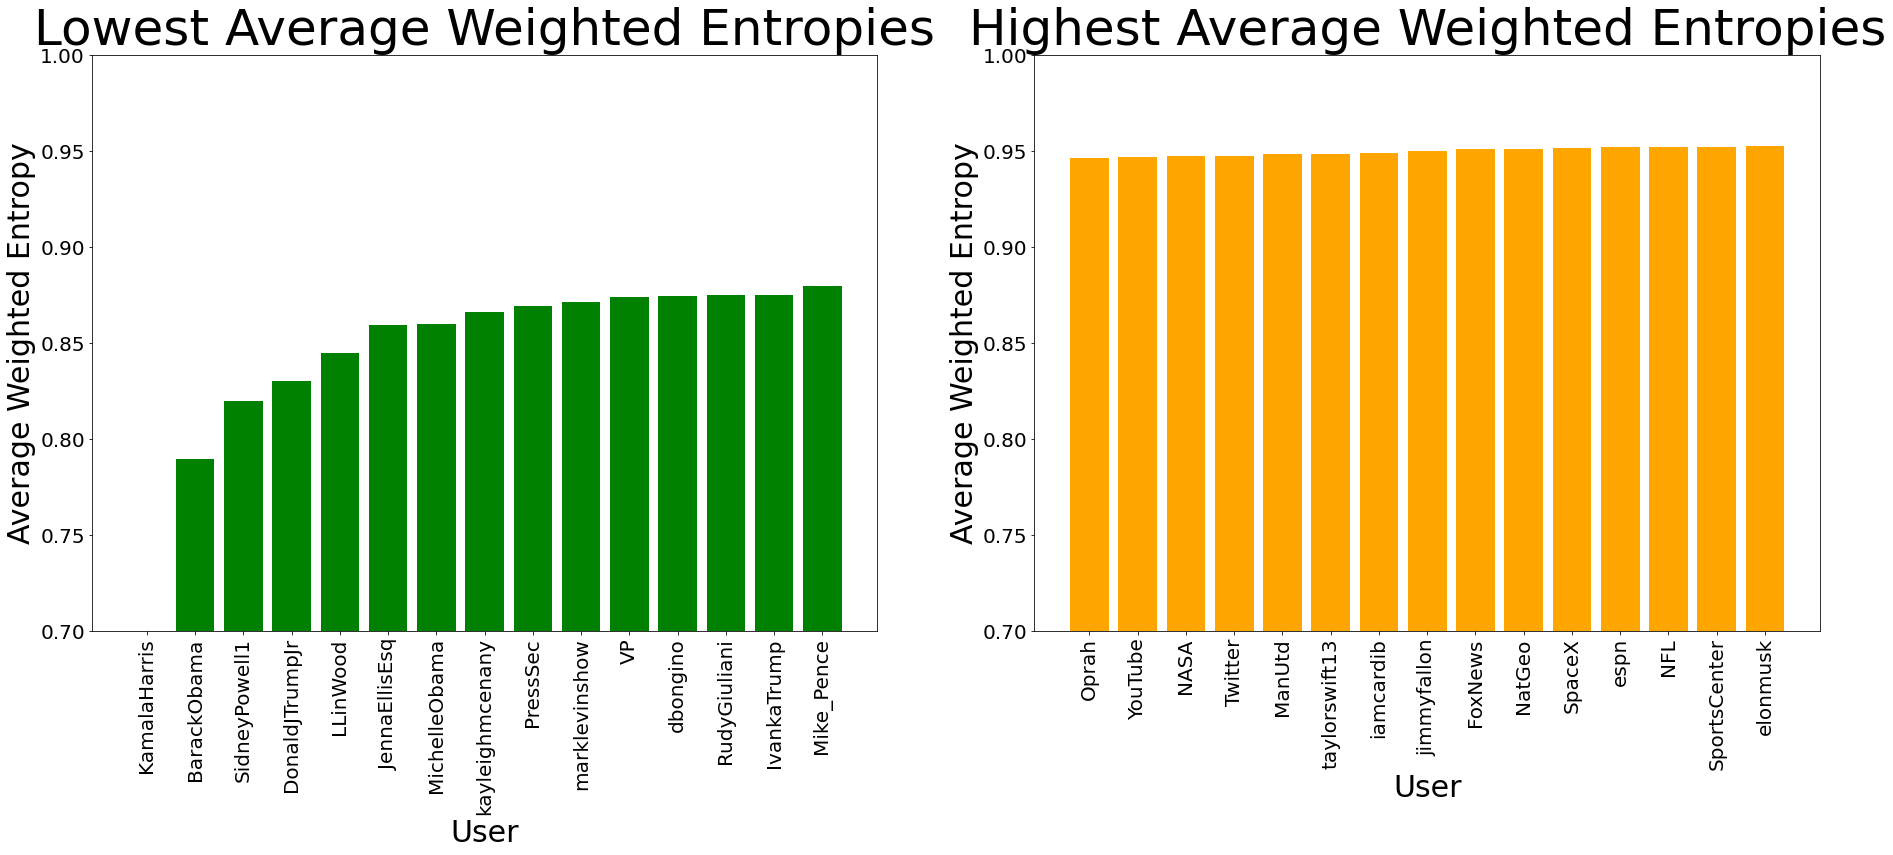

In [19]:

lowestEntropies = dict(counterWAE.most_common()[:-15-1:-1])
highestEntropies = dict(counterWAE.most_common(15)[::-1])


fig, ax = plt.subplots(1, 2)
ax[0].bar(lowestEntropies.keys(), lowestEntropies.values(), color='green')
ax[0].set_xlabel('User', fontsize=30)
ax[0].set_ylabel('Average Weighted Entropy', fontsize=30)
ax[0].tick_params(axis='x', rotation=90, labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('Lowest Average Weighted Entropies', fontsize=50)
ax[0].set_ylim(.7,1)
ax[1].bar(highestEntropies.keys(), highestEntropies.values(), color='orange')
ax[1].set_xlabel('User', fontsize=30)
ax[1].set_ylabel('Average Weighted Entropy', fontsize=30)
ax[1].tick_params(axis='x', rotation=90, labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_title('Highest Average Weighted Entropies', fontsize=50)
ax[1].set_ylim(.7,1)

fig.subplots_adjust(left=0, right=4, top=2, bottom=0)

#### Above is a zoomed in look at the column accounts with the most and least WAEs.

In [86]:
# Function that returns the column account with the lowest WAE
def findLowestSplit(dictOfWAE, matrix, topTeams, targetArray):
    sortedDict = sorted(dictOfWAE.items(), key = lambda x: x[1], reverse = False)
    return sortedDict[0][0]
team = findLowestSplit(dictOfwae, matrix, topTeamsList, targetArray)
print("Lowest entropy: ")
print(team)

Lowest entropy: 
KamalaHarris


In [87]:
# Function that creates a decision tree
def createTree(matrix, topTeams, targetArray):
    if len(matrix) < 5:
        return ""
    waeDict = createWAEDict(matrix, targetArray, topTeams)
    user = findLowestSplit(waeDict, matrix, topTeams, targetArray)
    if user != None:
        group1, group2, targetArray1, targetArray2 = createSubgroups(matrix, targetArray, topTeams, user)
    else:
        return ""
    print()
    print("Split by: ", user)
    print("Weighted entropy: ", waeDict[user])

    group1sEntropy = findShannonEntropy(group1, targetArray1, matrix)
    group2sEntropy = findShannonEntropy(group2, targetArray2, matrix)
    
    if group1sEntropy >= group2sEntropy:
        chaoticGroup = group1
        chaoticTA = targetArray1
        calmGroup = group2
        chaoticEntropy = group1sEntropy
        calmEntropy = group2sEntropy
    else:
        chaoticGroup = group2
        chaoticTA = targetArray2
        calmGroup = group1
        calmEntropy = group1sEntropy
        chaoticEntropy = group2sEntropy

    print("Chaotic group size: ", np.array(chaoticGroup).shape)
    print("Chaotic group entropy: ", chaoticEntropy)
    print("Calm group size: ", np.array(calmGroup).shape)
    print("Calm group entropy: ", calmEntropy)

    return createTree(chaoticGroup, topTeams, chaoticTA)
        

createTree(matrix, topTeamsList, targetArray)

    
    


Split by:  KamalaHarris
Weighted entropy:  0.7723905137309073
Chaotic group size:  (2049, 102)
Chaotic group entropy:  0.9471892423025271
Calm group size:  (656, 102)
Calm group entropy:  0.22641094842107642

Split by:  BarackObama
Weighted entropy:  0.8767153964118999
Chaotic group size:  (397, 102)
Chaotic group entropy:  0.9069917323375878
Calm group size:  (1652, 102)
Calm group entropy:  0.8694395457082085

Split by:  NASA
Weighted entropy:  0.8732053765431161
Chaotic group size:  (324, 102)
Chaotic group entropy:  0.9485637861183848
Calm group size:  (73, 102)
Calm group entropy:  0.5387379148665815

Split by:  POTUS
Weighted entropy:  0.9167405927683443
Chaotic group size:  (60, 102)
Chaotic group entropy:  0.9798687566511528
Calm group size:  (264, 102)
Calm group entropy:  0.9023932827949788

Split by:  EmmanuelMacron
Weighted entropy:  0.9140388267382651
Chaotic group size:  (57, 102)
Chaotic group entropy:  0.9621461334087001
Calm group size:  (3, 102)
Calm group entropy:  

''

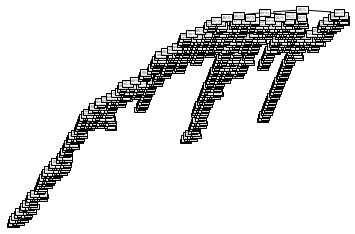

In [89]:
# Illustrates a decision tree using graphviz module
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(matrix, targetArray)

tree.plot_tree(clf)
dot_data = tree.export_graphviz(clf, out_file='decisionTree')
graph = graphviz.Source(dot_data)

## Making a Model

### We are going to train a model to predict the likelyhood of someone being either a Trump or Biden follower based on the other accounts (from the 84 teams) that they follow

#### First lets separate our data into a train and test set

In [25]:
trainX = matrix[25:-25]
trainY = targetArray[25:-25]
testX = np.concatenate((matrix[:25], matrix[-25:]), axis = 0)
testY = np.concatenate((targetArray[:25], targetArray[-25:]), axis = 0)

#### Now time to train our model. We have chosen to use BernoulliNB as our model from scikit-learn because it is easy to use and specifically designed for binary/boolean features

In [26]:
def evaluate(target, prediction):
    zipped = zip(target, prediction)
    FP = 0
    TP = 0
    FN = 0
    TN = 0
    for ans, pred in zipped:
        #print(ans, pred)
        if ans < pred:
            FP += 1
        elif ans > pred:
            FN += 1
        elif ans == 0:
            TP += 1
        elif ans == 1:
            TN += 1
        else:
            #print("error")
            pass
    return TP, TN, FP, FN

def train(model, trainingMatrix, trainingTargetArray, testMatrix, testTargetArray):
    model.fit(trainingMatrix, trainingTargetArray)
    prediction = model.predict(testMatrix)
    return evaluate(testTargetArray, prediction)

In [27]:
modelTrain = BernoulliNB()
print("Evaluated on training data\n")
TP, TN, FP, FN = train(modelTrain, trainX, trainY, trainX, trainY)
print("accuracy:", (TP + TN)/(TP + TN + FP + FN))
precision = (TP)/(TP + FP)
recall = (TP)/(TP + FN)
print("precision:", (TP)/(TP + FP))
print("recall:", (TP)/(TP + FN))
print("F1:", (2 * precision * recall)/(precision + recall))

modelTest = BernoulliNB()
print("\n\nEvaluated on test data\n")
TP, TN, FP, FN = train(modelTest, trainX, trainY, testX, testY)
print("accuracy:", (TP + TN)/(TP + TN + FP + FN))
precision = (TP)/(TP + FP)
recall = (TP)/(TP + FN)
print("precision:", (TP)/(TP + FP))
print("recall:", (TP)/(TP + FN))
print("F1:", (2 * precision * recall)/(precision + recall))

Evaluated on training data

accuracy: 0.7958568738229755
precision: 0.7389380530973452
recall: 0.8420168067226891
F1: 0.7871170463472112


Evaluated on test data

accuracy: 0.72
precision: 0.68
recall: 0.7391304347826086
F1: 0.7083333333333334


#### Our data consists of users that don't follow any of the column accounts, but because they follow Trump or Biden, they're included in our matrix. This could lower the accuracy of our model.
#### Below, we create smaller matrices and target arrays that only include users following a specific number of column accounts.

In [90]:
def makeSmallerMatrixTA(num, matrix, targetArray):
    newMatrix = []
    newTargetArray = []
    for index, person in enumerate(matrix):
        count=0
        notcount=0
        for x in person:
            if x ==1:
                count+=1
            else:
                notcount+=1
        if count >= num:
            newMatrix.append(person)
            newTargetArray.append(targetArray[index])
    return newMatrix, newTargetArray

def makeSmallerMatrix(num, matrix):
    newMatrix = []
    for index, person in enumerate(matrix):
        count=0
        notcount=0
        for x in person:
            if x ==1:
                count+=1
            else:
                notcount+=1
        if count >= num:
            newMatrix.append(person)
    return newMatrix

matrix1, targetArray1 = makeSmallerMatrixTA(1, matrix, targetArray)
matrix2, targetArray2 = makeSmallerMatrixTA(2, matrix, targetArray)
matrix3, targetArray3 = makeSmallerMatrixTA(3, matrix, targetArray)
matrix4, targetArray4 = makeSmallerMatrixTA(4, matrix, targetArray)
matrix5, targetArray5 = makeSmallerMatrixTA(5, matrix, targetArray)
matrix7, targetArray7 = makeSmallerMatrixTA(7, matrix, targetArray)
matrix10, targetArray10 = makeSmallerMatrixTA(10, matrix, targetArray)
matrix15, targetArray15 = makeSmallerMatrixTA(15, matrix, targetArray)
matrix20, targetArray20 = makeSmallerMatrixTA(20, matrix, targetArray)
matrix25, targetArray25 = makeSmallerMatrixTA(25, matrix, targetArray)
matrix30, targetArray30 = makeSmallerMatrixTA(30, matrix, targetArray)

matrixList = []
matrixList.append(matrix1)
matrixList.append(matrix2)
matrixList.append(matrix3)
matrixList.append(matrix4)
matrixList.append(matrix5)
matrixList.append(matrix7)
matrixList.append(matrix10)
matrixList.append(matrix15)
matrixList.append(matrix20)
matrixList.append(matrix25)
matrixList.append(matrix30)

targetArrayList = []
targetArrayList.append(targetArray1)
targetArrayList.append(targetArray2)
targetArrayList.append(targetArray3)
targetArrayList.append(targetArray4)
targetArrayList.append(targetArray5)
targetArrayList.append(targetArray7)
targetArrayList.append(targetArray10)
targetArrayList.append(targetArray15)
targetArrayList.append(targetArray20)
targetArrayList.append(targetArray25)
targetArrayList.append(targetArray30)

100%|██████████| 11/11 [00:00<00:00, 151.21it/s]

2705
2104
1736
1436
1222
1040
794
520
275
138
81
42
{1: 0.8104265402843602, 2: 0.7687861271676301, 3: 0.7552447552447552, 4: 0.7967479674796748, 5: 0.7980769230769231, 7: 0.810126582278481, 10: 0.8269230769230769, 15: 0.8518518518518519, 20: 0.9230769230769231, 25: 0.8888888888888888, 30: 1.0, 0: 0.72}


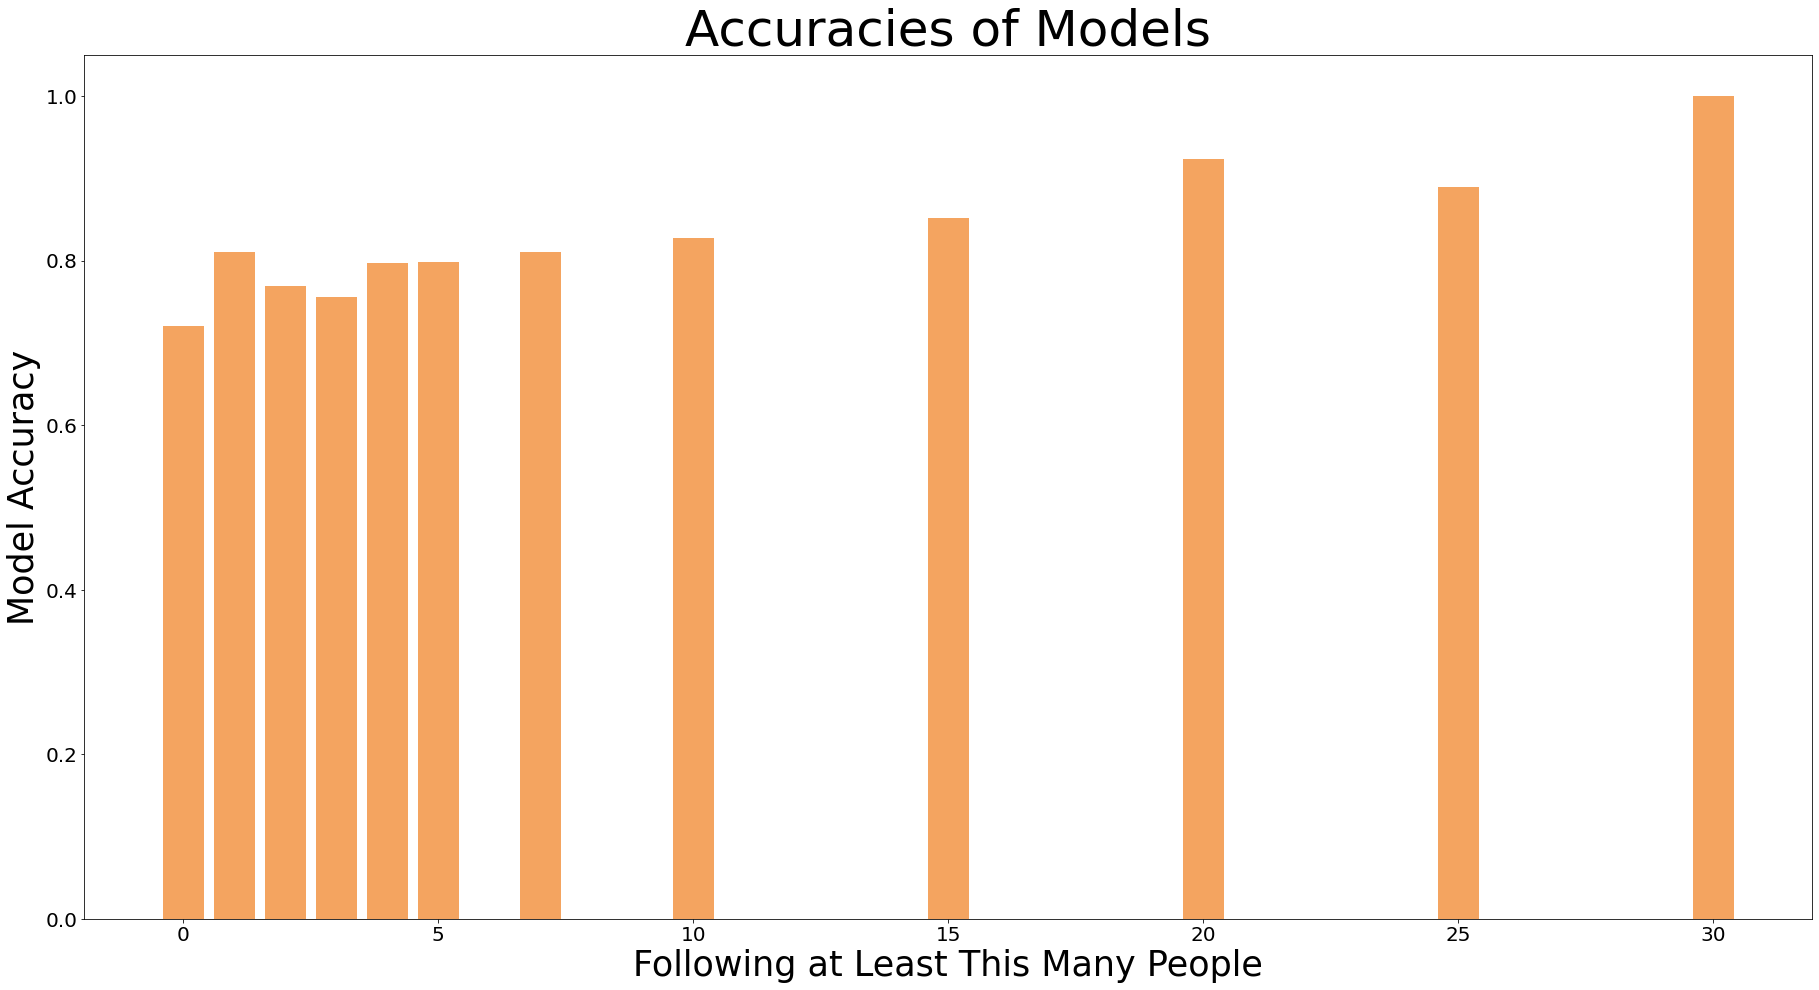

In [91]:
model = BernoulliNB()

def findModelsAccuracies(matrixList, targetArrayList, model):
    dictOfAccuracies = {}
    listOfNums = [1,2,3,4,5,7,10,15,20,25,30]
    for num in tqdm(range(len(matrixList))):
        matrix = matrixList[num]
        targetArray = targetArrayList[num]
        model.fit(matrix, targetArray)
        
        trainX = matrix[int(len(matrix)*(1/20)):int(len(matrix)*(19/20))]
        trainY = targetArray[int(len(matrix)*(1/20)):int(len(matrix)*(19/20))]
        testX = np.concatenate((matrix[:int(len(matrix)*(1/20))], matrix[int(len(matrix)*(19/20)):]), axis = 0)
        testY = np.concatenate((targetArray[:int(len(matrix)*(1/20))], targetArray[int(len(matrix)*(19/20)):]), axis = 0)
        
        TP, TN, FP, FN = train(model, trainX, trainY, testX, testY)
        
        accuracy = (TP + TN)/(TP + TN + FP + FN)
        dictOfAccuracies[listOfNums[num]] = accuracy
        print(len(matrix))
    return dictOfAccuracies
print(len(matrix))
accuracies = findModelsAccuracies(matrixList, targetArrayList, model)
accuracies[0] = .72
fig, ax = plt.subplots()
ax.bar(accuracies.keys(), accuracies.values(), color='sandybrown')
ax.set_title('Accuracies of Models', fontsize=50)
ax.set_xlabel('Following at Least This Many People', fontsize=35)
ax.set_ylabel('Model Accuracy', fontsize=35)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
fig.subplots_adjust(left=0,right=4,top=3,bottom=0)

print(accuracies)


#### Above is the distribution of accuracies of models that only include users following a certain amount of people. We can see that as the models include less and less people, it gets more accurate.

#### Next, we focus on the matrix that includes users following both Biden and Trump.

513


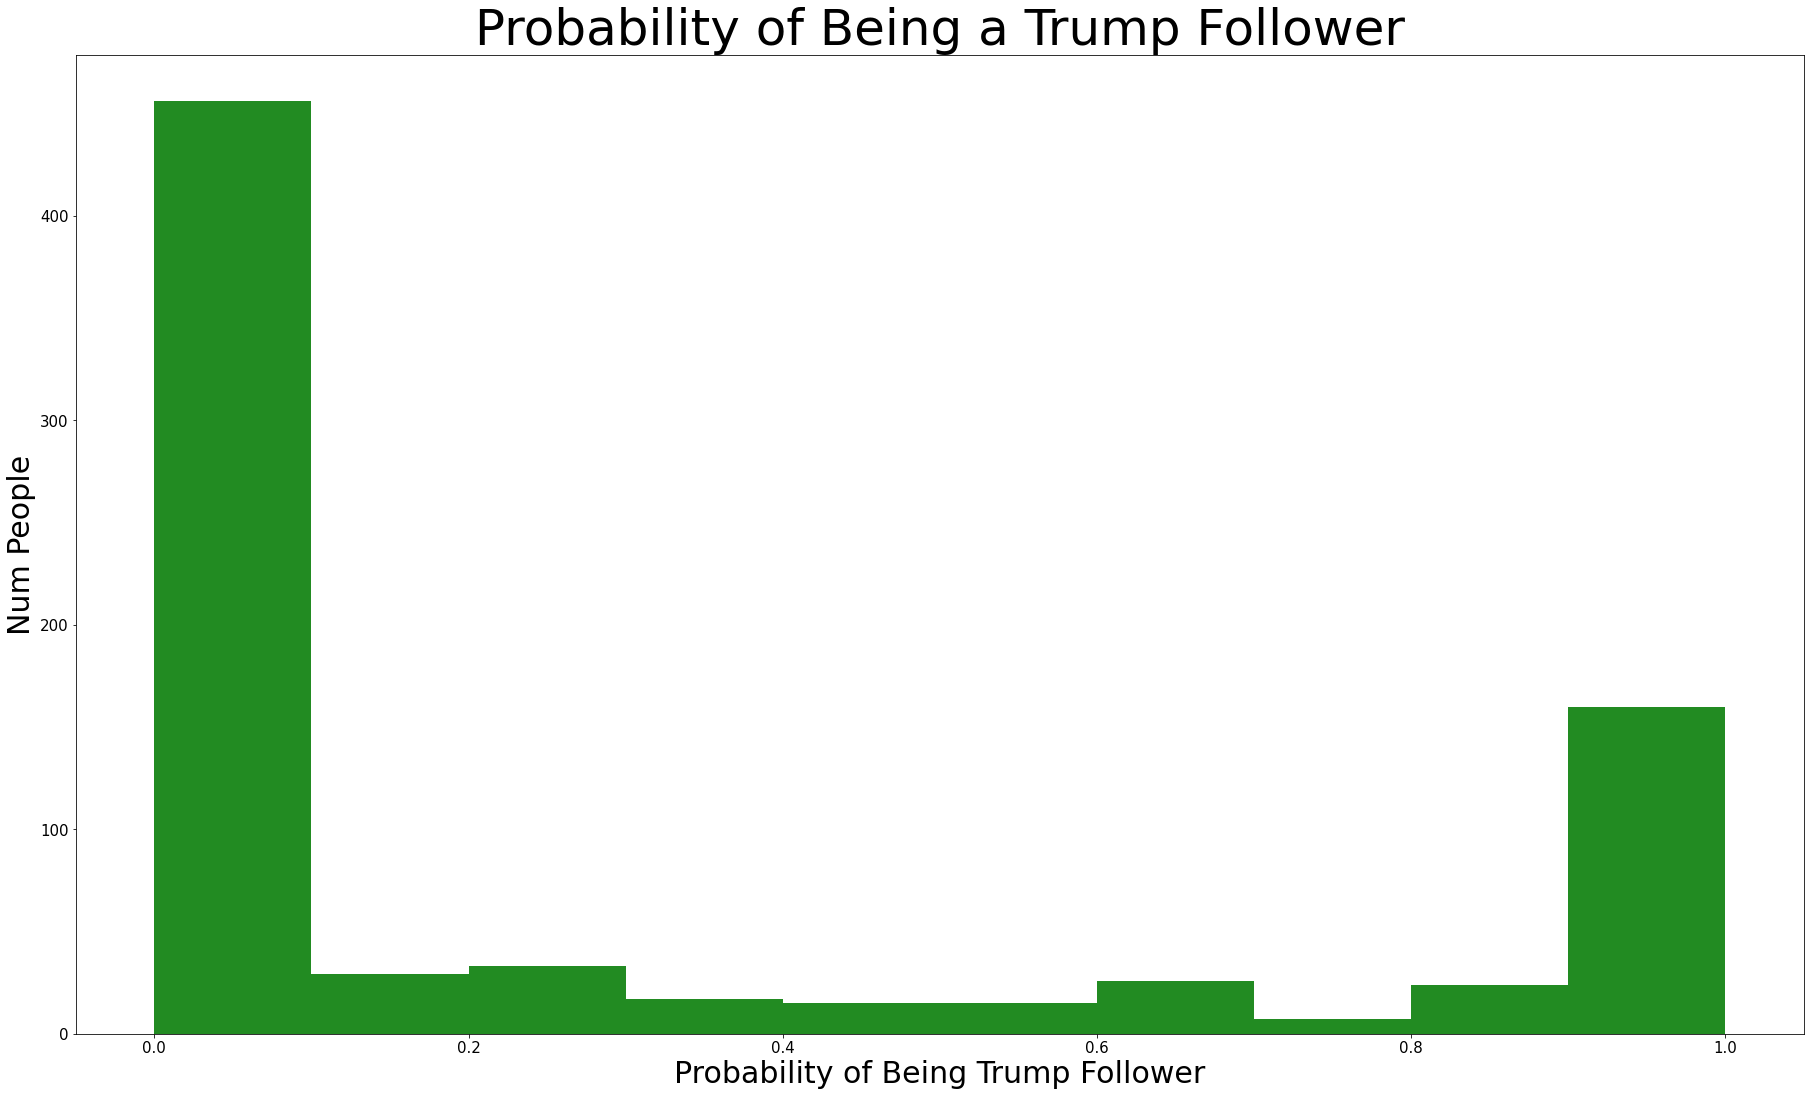

In [29]:
model = BernoulliNB()
model.fit(matrix, targetArray)

smallerBothMatrix = np.array(makeSmallerMatrix(5, bothMatrix))

predictionProba = model.predict_proba(bothMatrix.astype(np.float64))
print(len(smallerBothMatrix))
listOfTrumpProb = []
for pair in predictionProba:
    trumpProb = pair[1]
    listOfTrumpProb.append(trumpProb)

    
fig, ax = plt.subplots()
ax.hist(listOfTrumpProb, color='forestgreen')
ax.set_title('Probability of Being a Trump Follower', fontsize=50)
ax.set_ylabel('Num People', fontsize=30)
ax.set_xlabel('Probability of Being Trump Follower', fontsize=30)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
fig.subplots_adjust(left=0, right=4, bottom=0, top=3.4)

#### As we can see, users following both tend to be more likely to follow accounts aligned with Biden.

#### Thank you for looking at our code! We encourage you to reuse any parts of it that may help with future projects.